In [ ]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip

In [1]:
!unzip jena_climate_2009_2016.csv.zip

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


In [2]:
import os
fname = os.path.join('jena_climate_2009_2016.csv')

with open(fname) as f:
    data = f.read()
    
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [3]:
import numpy as np

In [6]:
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    temperature[i] = values[1]
    raw_data[i,:] = values[:]

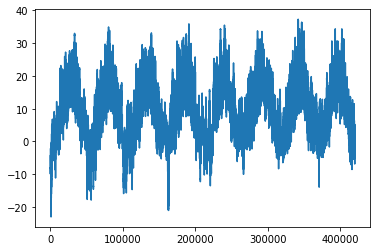

In [7]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

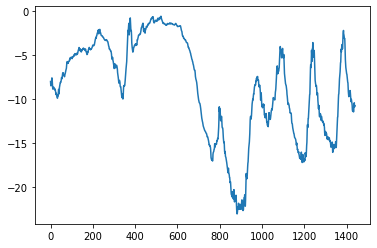

In [8]:
plt.plot(range(1440), temperature[:1440])

In [9]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print('num_train_samples: ', num_train_samples)
print('num_val_samples: ', num_val_samples)
print('num_test_samples: ', num_test_samples)

num_train_samples:  210225
num_val_samples:  105112
num_test_samples:  105114


In [10]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [12]:
import numpy as np
from tensorflow import keras

int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data = int_sequence[:-3],
    targets = int_sequence[3:],
    sequence_length = 3,
    batch_size = 2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


In [16]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets = temperature[delay:],
    sampling_rate = sampling_rate,
    sequence_length = sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples+num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate = sampling_rate,
    sequence_length=sequence_length,
    shuffle =True,
    batch_size=batch_size,
    start_index=num_train_samples+num_val_samples)

In [17]:
for samples, targets in train_dataset:
    print('samples shape: ', samples.shape)
    print('targets shape: ', targets.shape)
    break

samples shape:  (256, 120, 14)
targets shape:  (256,)


In [18]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:,-1,1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

In [19]:
print(f'Validation MAE: {evaluate_naive_method(val_dataset):.2f}')
print(f'Test MAE: {evaluate_naive_method(test_dataset):.2f}')

Validation MAE: 2.44
Test MAE: 2.62


In [22]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation='relu')(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint('jena_dense.keras', save_best_only=True)
]
model.compile(optimizer='rmsprop',
              loss='mse',
              metrics=['mae'])
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks)

Epoch 1/10
819/819 [==============================] - 29s 34ms/step - loss: 12.2827 - mae: 2.7102 - val_loss: 10.3996 - val_mae: 2.5296
Epoch 2/10
819/819 [==============================] - 30s 37ms/step - loss: 8.8729 - mae: 2.3397 - val_loss: 10.8768 - val_mae: 2.5978
Epoch 3/10
819/819 [==============================] - 30s 36ms/step - loss: 8.1601 - mae: 2.2504 - val_loss: 10.2039 - val_mae: 2.5111
Epoch 4/10
819/819 [==============================] - 30s 36ms/step - loss: 7.7311 - mae: 2.1890 - val_loss: 10.2738 - val_mae: 2.5145
Epoch 5/10
819/819 [==============================] - 30s 37ms/step - loss: 7.4399 - mae: 2.1497 - val_loss: 10.2618 - val_mae: 2.5077
Epoch 6/10
819/819 [==============================] - 32s 39ms/step - loss: 7.2093 - mae: 2.1149 - val_loss: 10.3621 - val_mae: 2.5240
Epoch 7/10
819/819 [==============================] - 31s 37ms/step - loss: 7.0364 - mae: 2.0902 - val_loss: 11.0238 - val_mae: 2.6081
Epoch 8/10
819/819 [==============================] - 

In [23]:
model = keras.models.load_model('jena_dense.keras')
print(f'Test MAE: {model.evaluate(test_dataset)[1]:.2f}')

405/405 [==============================] - 10s 24ms/step - loss: 11.4913 - mae: 2.6677
Test MAE: 2.67


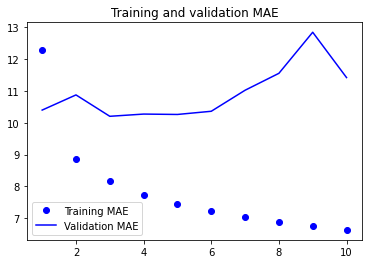

In [24]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training MAE')
plt.plot(epochs, val_loss, 'b', label='Validation MAE')
plt.title('Training and validation MAE')
plt.legend()
plt.show()

# actually used the wrong value for plotting, supposed to be mae, val_mae, not loss, val_loss

In [25]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation='relu')(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation='relu')(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation='relu')(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
callbacks = [
    keras.callbacks.ModelCheckpoint('jena_conv.keras',save_best_only=True)
]
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks)

Epoch 1/10
819/819 [==============================] - 58s 70ms/step - loss: 21.9591 - mae: 3.6641 - val_loss: 16.3005 - val_mae: 3.2036
Epoch 2/10
819/819 [==============================] - 58s 70ms/step - loss: 15.0528 - mae: 3.0739 - val_loss: 14.4428 - val_mae: 2.9901
Epoch 3/10
819/819 [==============================] - 60s 73ms/step - loss: 13.8483 - mae: 2.9455 - val_loss: 14.4165 - val_mae: 3.0061
Epoch 4/10
819/819 [==============================] - 60s 74ms/step - loss: 13.0852 - mae: 2.8600 - val_loss: 13.8521 - val_mae: 2.9346
Epoch 5/10
819/819 [==============================] - 60s 74ms/step - loss: 12.4552 - mae: 2.7925 - val_loss: 13.9120 - val_mae: 2.9327
Epoch 6/10
819/819 [==============================] - 61s 74ms/step - loss: 11.9629 - mae: 2.7382 - val_loss: 15.0835 - val_mae: 3.0656
Epoch 7/10
819/819 [==============================] - 64s 78ms/step - loss: 11.5189 - mae: 2.6875 - val_loss: 13.9076 - val_mae: 2.9317
Epoch 8/10
819/819 [============================

In [26]:
model = keras.models.load_model('jena_conv.keras')
print(f'Test MAE: {model.evaluate(test_dataset)[1]:.2f}')

405/405 [==============================] - 14s 32ms/step - loss: 15.5005 - mae: 3.1269
Test MAE: 3.13


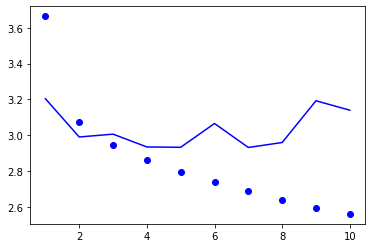

In [27]:
loss = history.history['mae']
val_loss = history.history['val_mae']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'bo')
plt.plot(epochs, val_loss, 'b')
plt.show()

In [28]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, 
                    callbacks=keras.callbacks.ModelCheckpoint('jena_lstm.keras', save_best_only=True))

Epoch 1/10
819/819 [==============================] - 96s 115ms/step - loss: 39.6009 - mae: 4.5738 - val_loss: 12.2923 - val_mae: 2.6699
Epoch 2/10
819/819 [==============================] - 97s 118ms/step - loss: 10.8642 - mae: 2.5629 - val_loss: 9.6154 - val_mae: 2.3965
Epoch 3/10
819/819 [==============================] - 88s 107ms/step - loss: 9.7496 - mae: 2.4354 - val_loss: 9.6434 - val_mae: 2.3904
Epoch 4/10
819/819 [==============================] - 88s 108ms/step - loss: 9.3251 - mae: 2.3821 - val_loss: 9.5921 - val_mae: 2.3853
Epoch 5/10
819/819 [==============================] - 89s 108ms/step - loss: 9.0176 - mae: 2.3423 - val_loss: 10.0928 - val_mae: 2.4410
Epoch 6/10
819/819 [==============================] - 91s 110ms/step - loss: 8.7476 - mae: 2.3070 - val_loss: 9.7181 - val_mae: 2.3956
Epoch 7/10
819/819 [==============================] - 89s 108ms/step - loss: 8.5635 - mae: 2.2822 - val_loss: 10.1442 - val_mae: 2.4530
Epoch 8/10
819/819 [==============================

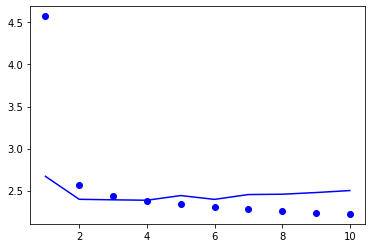

In [29]:
loss = history.history['mae']
val_loss = history.history['val_mae']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'bo')
plt.plot(epochs, val_loss, 'b')
plt.show()

In [30]:
model = keras.models.load_model('jena_lstm.keras')
print(f'Test MAE: {model.evaluate(test_dataset)[1]:.2f}')

405/405 [==============================] - 18s 44ms/step - loss: 10.7912 - mae: 2.5796
Test MAE: 2.58


In [ ]:
# pseudocode RNN

state_t = 0

for input_t in input_sequence:
    output_t = f(input_t, state_t)
    state_t = output_t

In [ ]:
# more-detailed pseudocode RNN

state_t = 0

for input_t in input_sequence:
    output_t = activation(dot(W, input_t) + dot(U, state_t) + b)
    state_t = output_t

In [31]:
import numpy as np

In [32]:
timesteps = 100
input_features = 32
output_features = 64

inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,))
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))
successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t
final_output_sequence = np.stack(successive_outputs, axis=0)

In [34]:
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

In [35]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=False)(inputs)
print(outputs.shape)

(None, 16)


In [36]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=True)(inputs)
print(outputs.shape)

(None, 120, 16)


In [37]:
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)

In [38]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint('jena_lstm_dropout.keras',save_best_only=True)
]

model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
history = model.fit(train_dataset, epochs=50, validation_data=val_dataset, callbacks=callbacks)

Epoch 1/50
819/819 [==============================] - 149s 178ms/step - loss: 29.4337 - mae: 3.9831 - val_loss: 9.7702 - val_mae: 2.4145
Epoch 2/50
819/819 [==============================] - 155s 189ms/step - loss: 14.8115 - mae: 2.9898 - val_loss: 9.4440 - val_mae: 2.3767
Epoch 3/50
819/819 [==============================] - 172s 209ms/step - loss: 13.8710 - mae: 2.8890 - val_loss: 9.1018 - val_mae: 2.3345
Epoch 4/50
819/819 [==============================] - 150s 183ms/step - loss: 13.1970 - mae: 2.8192 - val_loss: 9.3403 - val_mae: 2.3712
Epoch 5/50
819/819 [==============================] - 160s 195ms/step - loss: 12.6461 - mae: 2.7571 - val_loss: 9.1589 - val_mae: 2.3458
Epoch 6/50
819/819 [==============================] - 152s 185ms/step - loss: 12.3205 - mae: 2.7252 - val_loss: 9.7995 - val_mae: 2.4378
Epoch 7/50
819/819 [==============================] - 152s 185ms/step - loss: 11.9311 - mae: 2.6836 - val_loss: 9.1654 - val_mae: 2.3430
Epoch 8/50
 87/819 [==>..................

KeyboardInterrupt: 


This takes way too long to train... let's just pretend it's better......
------------------------------------------------------------------------

In [42]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks=[keras.callbacks.ModelCheckpoint('jena_stacked_gru_dropout.keras', save_best_only=True)]

model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
history = model.fit(train_dataset, epochs=50, validation_data=val_dataset, callbacks=callbacks)

Epoch 1/50
819/819 [==============================] - 267s 318ms/step - loss: 24.9145 - mae: 3.6948 - val_loss: 9.4712 - val_mae: 2.3741
Epoch 2/50
819/819 [==============================] - 242s 295ms/step - loss: 14.0537 - mae: 2.9070 - val_loss: 9.1125 - val_mae: 2.3366
Epoch 3/50
819/819 [==============================] - 285s 347ms/step - loss: 13.1445 - mae: 2.8109 - val_loss: 8.7885 - val_mae: 2.2930
Epoch 4/50
819/819 [==============================] - 253s 308ms/step - loss: 12.5174 - mae: 2.7415 - val_loss: 8.6747 - val_mae: 2.2810
Epoch 5/50
819/819 [==============================] - 262s 320ms/step - loss: 12.0615 - mae: 2.6913 - val_loss: 8.7810 - val_mae: 2.2909
Epoch 6/50
819/819 [==============================] - 261s 318ms/step - loss: 11.6419 - mae: 2.6457 - val_loss: 8.8560 - val_mae: 2.3015
Epoch 7/50
819/819 [==============================] - 236s 289ms/step - loss: 11.2645 - mae: 2.6047 - val_loss: 9.1486 - val_mae: 2.3482
Epoch 8/50
819/819 [=====================

KeyboardInterrupt: 

In [41]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset,
                   callbacks=[keras.callbacks.ModelCheckpoint('jena_bidirectional.keras',
                                                              save_best_only=True)])

Epoch 1/10
819/819 [==============================] - 136s 160ms/step - loss: 27.5414 - mae: 3.7471 - val_loss: 9.8794 - val_mae: 2.4345
Epoch 2/10
819/819 [==============================] - 124s 151ms/step - loss: 9.5807 - mae: 2.4107 - val_loss: 9.5795 - val_mae: 2.4202
Epoch 3/10
819/819 [==============================] - 112s 136ms/step - loss: 8.5856 - mae: 2.2829 - val_loss: 10.3515 - val_mae: 2.5106
Epoch 4/10
819/819 [==============================] - 120s 147ms/step - loss: 7.8986 - mae: 2.1946 - val_loss: 10.2441 - val_mae: 2.4930
Epoch 5/10
819/819 [==============================] - 121s 147ms/step - loss: 7.4248 - mae: 2.1279 - val_loss: 10.9233 - val_mae: 2.5782
Epoch 6/10
819/819 [==============================] - 122s 149ms/step - loss: 7.0722 - mae: 2.0760 - val_loss: 11.0126 - val_mae: 2.5903
Epoch 7/10
 31/819 [>.............................] - ETA: 1:40 - loss: 7.0354 - mae: 2.0758

KeyboardInterrupt: 